# 1DoF Hamilton Saddle-Node

We study the _Hamilton Saddle-node_ (HSN) system with Hamiltonian

\begin{equation}
H_{SN} = \frac{1}{2} p^2 - \sqrt{\mu}q^2 + \frac{1}{3}q^3
\end{equation}

and associated _Hamilton equations_

\begin{align}
\dot{q} &= \frac{\partial H_{SN}}{\partial p} = p\\
\dot{p} &= -\frac{\partial H_{SN}}{\partial q} = 2\sqrt{\mu}q - q^2
\end{align}

The _equilibrium points_ for this system are located at $(0,0)$ (_saddle point_) and $(2\sqrt{\mu},0)$ (_centre point_), where $\mu$ is the _biurcation parameter_, which clearly controls the distance between these points. When, $\mu < 0$, no equilibrium points exist. 

## Phase Portraits

We're interested in the case when equilibrium points exist, since invariant manifolds are observed.

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy
from numpy import arange
from numpy import meshgrid

<IPython.core.display.Javascript object>


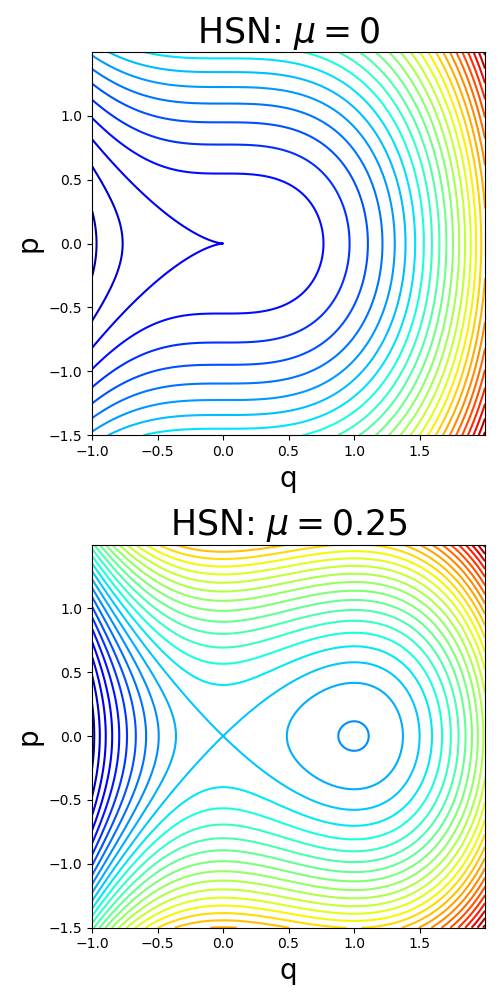

In [2]:
# Mesh of initial conditions in 2D plane
delta = 0.001
xrange = arange(-1, 2.0, delta)
yrange = arange(-1.5, 1.5, delta)
q0, p0 = meshgrid(xrange,yrange)

# Plot vector field
fig,ax = plt.subplots(2,1,figsize=(5,10),dpi=100)

#########################################
# Parameters for Ham Saddle-Node
MU = 0
ALPHA = 1
# Hamiltonian
H0 = 0.5*p0**2 - numpy.sqrt(MU)*q0**2 + ALPHA*q0**3/3
ax[0].set_title('HSN: $\mu = 0$', fontsize=25)
ax[0].set_xlabel('q', fontsize=20)
ax[0].set_ylabel('p', fontsize=20)
ax[0].contour(q0,p0,H0,40,cmap='jet')
#########################################
# Parameters for Ham Saddle-Node
MU = 0.25
ALPHA = 1
# Hamiltonian
H0 = 0.5*p0**2 - numpy.sqrt(MU)*q0**2 + ALPHA*q0**3/3
ax[1].set_title('HSN: $\mu = 0.25$', fontsize=25)
ax[1].set_xlabel('q', fontsize=20)
ax[1].set_ylabel('p', fontsize=20)
ax[1].contour(q0,p0,H0,40,cmap='jet')
#########################################
# Parameters for Ham Saddle-Node
# MU = 0.25
# ALPHA = 1
# # Hamiltonian
# H0 = 0.5*p0**2 - numpy.sqrt(MU)*q0**2 + ALPHA*q0**3/3
# ax[2].set_title('Phase-Space Portrait Hamilton-SN', fontsize=20)
# ax[2].set_xlabel('q', fontsize=20)
# ax[2].set_ylabel('p', fontsize=20)
# ax[2].contour(q0,p0,H0,40,cmap='Blues')

fig.tight_layout()
plt.show()

# Numerical solution and Invertibility of $D_0^1$ data matrices

* Initial conditions: $(q_0, p_0) = (q(t_0), p(t_0))$, were sampled from square grid of $N \times N$ points in phase-space
* We integrated ONLY for a single timestep, $\Delta t$, i.e.,  $(q(t), p(t))$, with $t = t_0 + \Delta t$
* We used _Explicit Runge-Kutta_ of order 5, implemented as part of the Python library `scipy.integrate`

<span style='color:red'>CHECK</span>
* Meaning and values of the relative and absolute tolerance variables defined in numeric integrator
* Do I need quadruple presicion?

_TASK 1_ (<span style='color:blue'>DONE</span>): Data matrices $D_0^1$ as before

\begin{equation*}
D_0^1 = 
\begin{bmatrix}
\begin{pmatrix}
q_0\\
p_0
\end{pmatrix}
\begin{pmatrix}
q\\
p
\end{pmatrix}
\end{bmatrix}
\end{equation*}

and compute their determinant $det(D_0^1)$ to tests for invertibility

_TASK 2_ : Compare the trajectory-based operator with the nonlinear flow

* Compute $\mathbb{E}[\hat{A}]$, with $\hat{A}$ defined according to DMD as before

\begin{equation*}
\hat{A} = 
\begin{pmatrix}
q\\
p
\end{pmatrix}
\begin{pmatrix}
q_0\\
p_0
\end{pmatrix}^+
\end{equation*}

Take average for all initial conditons

* Determine the _average relative error_  $\mathbb{E}[\varepsilon]$  between the prediction of the first timestep $\hat{\mathbf{r}} = (\hat{q}, \hat{p})^T$ (time $(t_0 + \Delta t)$) from the dynamics generated by $\mathbb{E}[\hat{A}]$ and the _numerical prediction_ $\mathbf{r} = (q, p)^T$ from solving the ODEs of the system, for a set of sampled of initial conditions $\mathbf{r}_0 = (q_0, p_0)^T$ from the 2D phase-space 

We define the _relative error_ between predictions per initial condition as

\begin{equation}
\varepsilon(\mathbf{r}_0) = \frac{\lVert \mathbf{r} - \hat{\mathbf{r}} \rVert}{\lVert \mathbf{r}\rVert}
\end{equation}

or expressed differently,

\begin{equation}
\varepsilon(\mathbf{r}_0) = \frac{\lVert \phi_{\Delta t}(\mathbf{r}_0) - \mathbb{E}[\hat{A}] \mathbf{r}_0 \rVert}{ \lVert \phi_{\Delta t}(\mathbf{r}_0) \rVert}
\end{equation}

In [99]:
D01_det_hsn = {}
D01_det_hsn['original'] = []
D01_det_hsn['translated'] = []

## Case $\mu = 0$

### Routine for Numerical Soltution

#### _LSODA_ Fortran solver

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

In [6]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
MU = 0
ALPHA = 1
# Bundle parameters for ODE solver
params = [MU, ALPHA]

def f(y, t, params):
    q, p = y      # unpack current values of y
    MU, ALPHA = params  # unpack parameters
    derivs = [p, 2*numpy.sqrt(MU)*q - q**2]     # list of dy/dt=f functions
    return derivs
###########################################
#
# Meshgrid of initial conditions (q0,p0)
#
###########################################
# Grid limits
x_min, x_max = (-1.5, 1.5)
y_min, y_max = (-1.5, 1.5)
# Number of grid points per axis
N = 200
# Grid resolution per axis
x_res = (x_max - x_min)/float(N)
y_res = x_res
# Construct grid for the above params
x = np.arange(x_min, x_max, x_res)
y = np.arange(y_min, y_max, y_res)
X,Y = np.meshgrid(x, y)
###########################################
#
# Make time array for solution
#
###########################################
n_steps = 1
t0 = 0.
dt = 0.02 # Time increment
t_final = t0 + n_steps*dt
t = np.arange(t0, t_final+dt, dt)
###########################################
#
# Solve ODEs for every initial condition in grid
#
###########################################
D01_det_data = []
A_hat_data = []
grid_points = []
trajectory = {}
for i in range(len(X[0])):
    trajectory[i] = {}    
    for j in range(len(Y[0])):
        q0 = float(X[i][j])
        p0 = float(Y[i][j])
        grid_points.append([q0, p0])
        ###########################################
        #
        # Solve ODEs for initial conditions (q0, p0)
        #
        ###########################################
        # Bundle initial conditions for ODE solver
        y0 = [q0, p0]
        # Call ODE solver
        solution = odeint(f, y0, t, args=(params,))
        # Vector for next step in evolution and its P-inverse
        trajectory[i][j] = solution
        ###########################################
        #
        # Data matrices and their determinant 
        #
        ###########################################
        # Column vector of IC.s and its MP-pseudoinverse
        q0, p0 = solution[0]
        r0 = numpy.matrix([q0, p0]).T
        q, p = solution[1]
        r = numpy.matrix([q, p]).T
        # Data matrix D_0^1
        D01 = numpy.asmatrix(numpy.concatenate([[r0],[r]])).T
        D01_det = numpy.linalg.det(D01)
        D01_det_data.append(D01_det)
        ###########################################
        #
        # Trajectory-based operator for IC
        #
        ###########################################
        r0_pinv = r0.T/float(numpy.linalg.norm(r0)**2)
        A_hat = numpy.matmul(r, r0_pinv)
        A_hat_data.append(A_hat)

#### Runge-Kutta 4th order solver

<span style='color:red'>UNDER CONSTRUCTION</span>

### Invertibility Plot of $D_0^1$ matrices

<IPython.core.display.Javascript object>


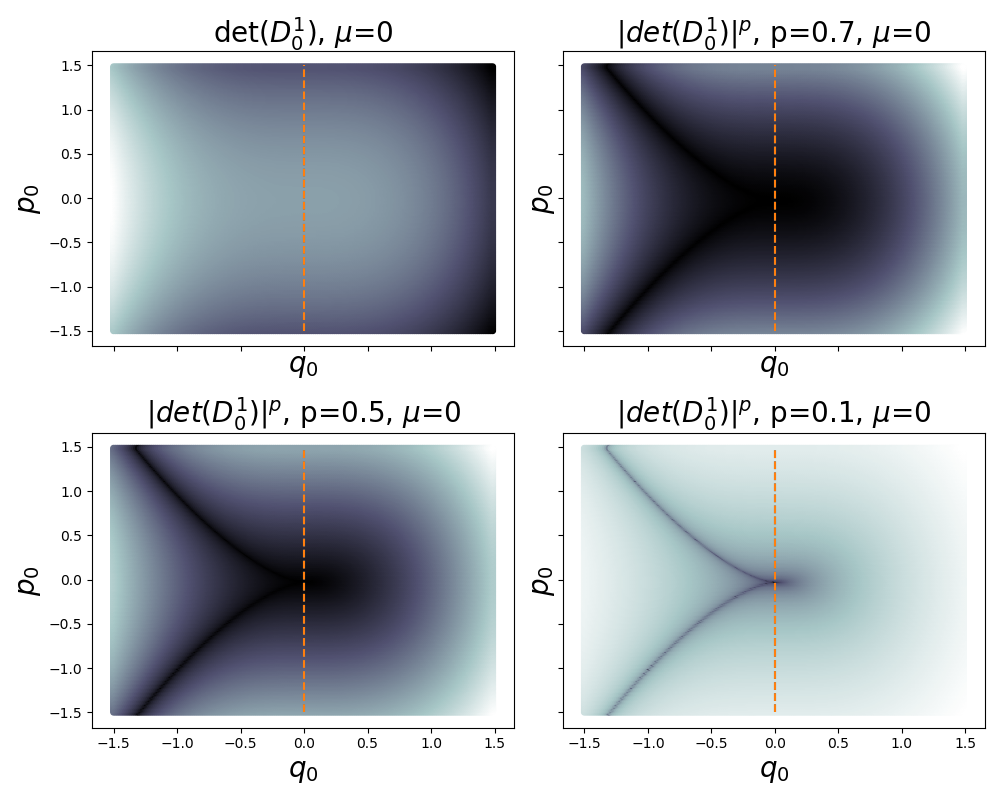

In [7]:
import matplotlib
fig,ax = plt.subplots(2,2,figsize=(10,8), sharex =True, sharey=True)

x,y = numpy.asarray(grid_points).T

############################################
i,j=(0,0)
ax[i][j].scatter(x,y,c=D01_det_data,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title('det($D_0^1$), $\mu$=0', fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)

############################################
p1 = 0.7
i,j=(0,1)
ax[i][j].scatter(x,y,c=numpy.abs(D01_det_data)**p1,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title("$\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p1)+", $\mu$=0", fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)

############################################
p2 = 0.5
i,j=(1,0)
ax[i][j].scatter(x,y,c=numpy.abs(D01_det_data)**p2,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title("$\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p2)+", $\mu$=0", fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)


############################################
p3 = 0.1
i,j=(1,1)
ax[i][j].scatter(x,y,c=numpy.abs(D01_det_data)**p3,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title("$\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p3)+", $\mu$=0", fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)


fig.tight_layout()
plt.show()

### Dynamics generated by $\mathbb{E}[\hat{A}]$ VS $\phi_{\Delta t}$

In [595]:
A_hat_mean = numpy.array(A_hat_data).mean(axis=0)

In [574]:
def Hamiltonian_SN(r):
    q,p = r
    H = 0.5*p**2 - numpy.sqrt(MU)*q**2 + ALPHA*q**3/3
    return H

In [575]:
def relative_error(r_num, r_traj):
    error = numpy.linalg.norm(r_traj - r_num)/float(numpy.linalg.norm(r_num))
    return error

In [576]:
H0 = np.zeros_like(X)
H_traj = np.zeros_like(X)
H_traj_corrected = np.zeros_like(X)
f = 2 # form factor
H_num = np.zeros_like(X)
dH = np.zeros_like(X)
RelativeError = np.zeros_like(X)
for i in range(len(X[0])):
    for j in range(len(Y[0])):
        # Initial condition
        r0 = numpy.asmatrix([X[i][j], Y[i][j]]).T
        ############################################
        H0[i][j] = Hamiltonian_SN(numpy.asarray(r0.T)[0])
        ############################################
        # Next timestep in the dynamics of traj-based operator
        r_traj = numpy.matmul(A_hat_mean, r0)
        r_traj_corrected = 2*numpy.matmul(A_hat_mean, r0)
        # Next timestep in the dynamics from numerical solution
        H_traj[i][j] = Hamiltonian_SN(numpy.asarray(r_traj.T)[0])
        H_traj_corrected[i][j] = Hamiltonian_SN(numpy.asarray(r_traj_corrected.T)[0])
        ############################################
        r_num = numpy.asmatrix(trajectory[i][j][-1])
        H_num[i][j] = Hamiltonian_SN(numpy.asarray(r_num)[0])
        ############################################
        dH[i][j] = abs(H_traj[i][j] - H_num[i][j])
        ############################################
        RelativeError[i][j] = relative_error(numpy.asarray(r_num)[0], numpy.asarray(r_traj.T)[0])
        

<IPython.core.display.Javascript object>


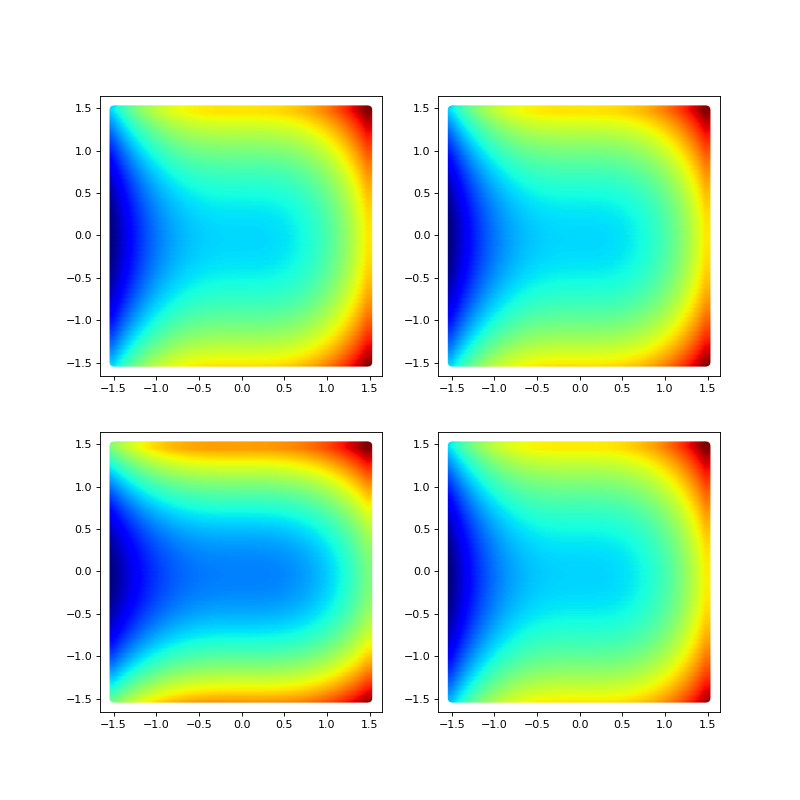

In [577]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0][0].scatter(X, Y, c = H0, cmap = 'jet')
ax[0][1].scatter(X, Y, c = H_num, cmap = 'jet')
ax[1][0].scatter(X, Y, c = H_traj, cmap = 'jet')
ax[1][1].scatter(X, Y, c = H_traj_corrected, cmap = 'jet')

plt.show()

<IPython.core.display.Javascript object>


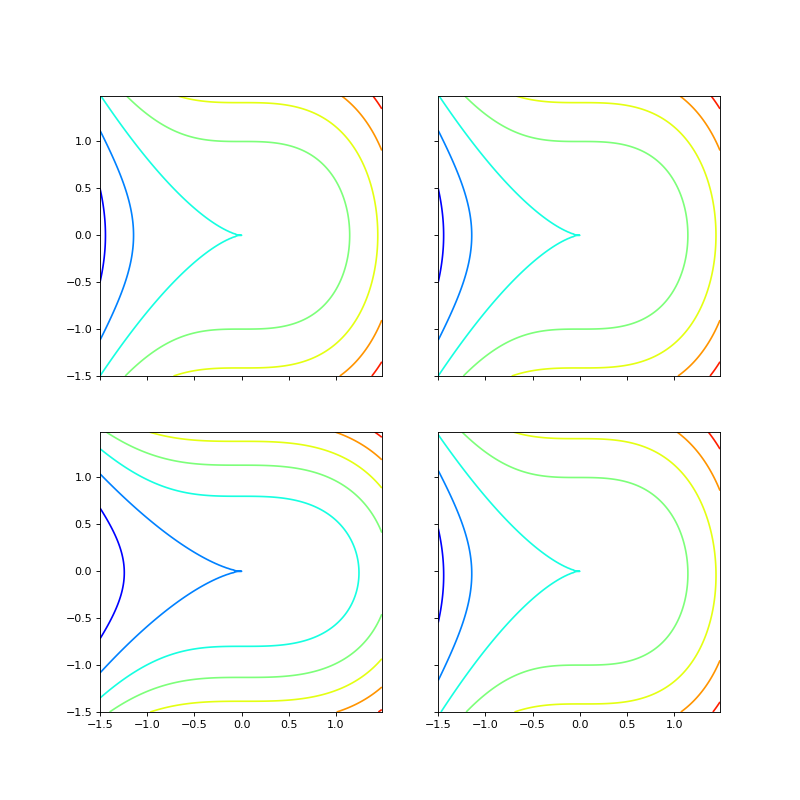

In [578]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

ax[0][0].contour(X, Y, H0, cmap = 'jet')
ax[0][1].contour(X, Y, H_num, cmap = 'jet')
ax[1][0].contour(X, Y, H_traj, cmap = 'jet')
ax[1][1].contour(X, Y, H_traj_corrected, cmap = 'jet')

plt.show()

In [579]:
numpy.mean(RelativeError), numpy.std(RelativeError)

(0.5000922158674651, 0.0034742744998045253)

In [593]:
A_hat_mean

array([[0.50010169, 0.010026  ],
       [0.01014551, 0.50013338]])

In [581]:
2*A_hat_mean

array([[1.00000338e+00, 2.00506506e-02],
       [2.89628640e-04, 1.00006574e+00]])

<span style='color:red'>OBSERVARION</span>
Need to multiply A

## Case $\mu > 0$

### Routine for Numerical Soltution

In [100]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
MU = 0.25
ALPHA = 1
# Bundle parameters for ODE solver
params = [MU, ALPHA]

def f(y, t, params):
    q, p = y      # unpack current values of y
    MU, ALPHA = params  # unpack parameters
    derivs = [p, 2*numpy.sqrt(MU)*q - q**2]     # list of dy/dt=f functions
    return derivs
###########################################
#
# Meshgrid of initial conditions (q0,p0)
#
###########################################
# Grid limits
x_min, x_max = (-1.5, 1.5)
y_min, y_max = (-1.5, 1.5)
# Number of grid points per axis
N = 200
# Grid resolution per axis
x_res = (x_max - x_min)/float(N)
y_res = x_res
# Construct grid for the above params
x = np.arange(x_min, x_max, x_res)
y = np.arange(y_min, y_max, y_res)
X,Y = np.meshgrid(x, y)
###########################################
#
# Make time array for solution
#
###########################################
n_steps = 1
t0 = 0.
t_final = t0 + n_steps*dt
dt = 0.02 # Time increment
t = np.arange(t0, t_final+dt, dt)
###########################################
#
# Solve ODEs for every initial condition in grid
#
###########################################
D01_det_data = []
A_hat_data = []
grid_points = []
trajectory = {}
for i in range(len(X[0])):
    trajectory[i] = {}    
    for j in range(len(Y[0])):
        q0 = float(X[i][j])
        p0 = float(Y[i][j])
        grid_points.append([q0, p0])
        ###########################################
        #
        # Solve ODEs for initial conditions (q0, p0)
        #
        ###########################################
        # Bundle initial conditions for ODE solver
        y0 = [q0, p0]
        # Call ODE solver
        solution = odeint(f, y0, t, args=(params,))
        # Vector for next step in evolution and its P-inverse
        trajectory[i][j] = solution
        ###########################################
        #
        # Data matrices and their determinant 
        #
        ###########################################
        # Column vector of IC.s and its MP-pseudoinverse
        q0, p0 = solution[0]
        r0 = numpy.matrix([q0, p0]).T
        q, p = solution[1]
        r = numpy.matrix([q, p]).T
        # Data matrix D_0^1
        D01 = numpy.asmatrix(numpy.concatenate([[r0],[r]])).T
        D01_det = numpy.linalg.det(D01)
        D01_det_data.append(D01_det)
        ###########################################
        #
        # Trajectory-based operator for IC
        #
        ###########################################
        r0_pinv = r0.T/float(numpy.linalg.norm(r0)**2)
        A_hat = numpy.matmul(r, r0_pinv)
        A_hat_data.append(A_hat)

In [101]:
D01_det_hsn['original'] = D01_det_data

### Invertibility Plot of $D_0^1$ matrices

<IPython.core.display.Javascript object>


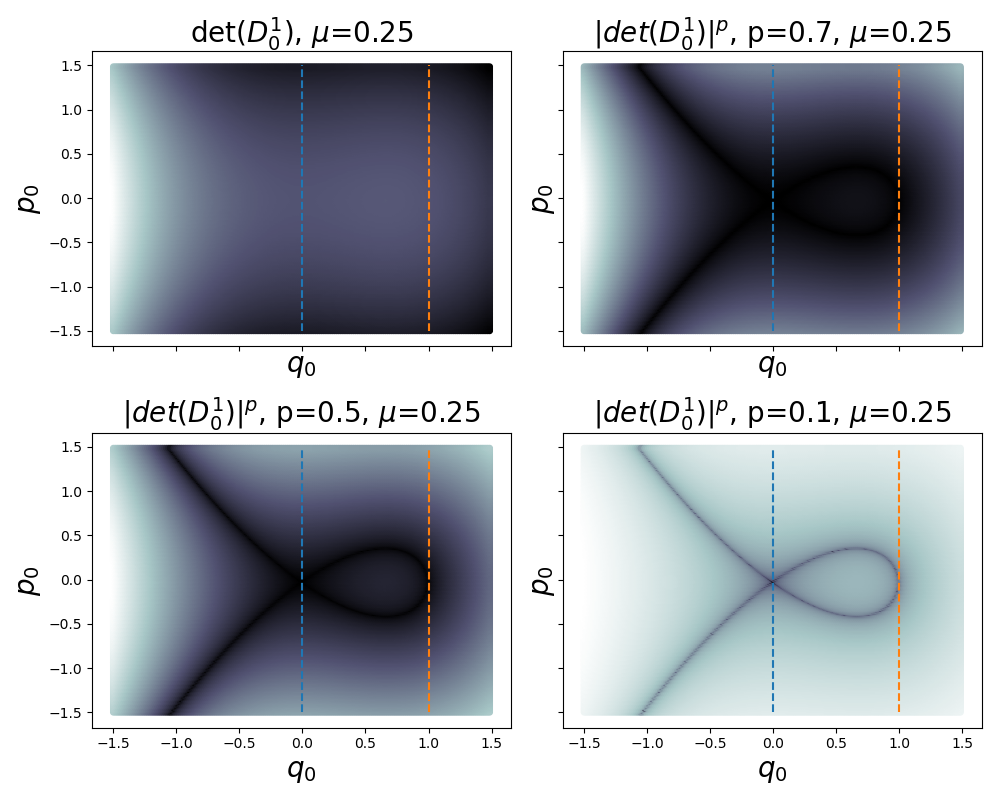

In [82]:
import matplotlib
fig,ax = plt.subplots(2,2,figsize=(10,8), sharex =True, sharey=True)

x,y = numpy.asarray(grid_points).T

############################################
i,j=(0,0)
ax[i][j].scatter(x,y,c=D01_det_data,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title('det($D_0^1$), $\mu$=0.25', fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)

############################################
p1 = 0.7
i,j=(0,1)
ax[i][j].scatter(x,y,c=numpy.abs(D01_det_data)**p1,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title("$\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p1)+", $\mu$=0.25", fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)

############################################
p2 = 0.5
i,j=(1,0)
ax[i][j].scatter(x,y,c=numpy.abs(D01_det_data)**p2,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title("$\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p2)+", $\mu$=0.25", fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)


############################################
p3 = 0.1
i,j=(1,1)
ax[i][j].scatter(x,y,c=numpy.abs(D01_det_data)**p3,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title("$\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p3)+", $\mu$=0.25", fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)


fig.tight_layout()
plt.show()

### Dynamics generated by $\mathbb{E}[\hat{A}]$ VS $\phi_{\Delta t}$

In [584]:
A_hat_mean = numpy.array(A_hat_data).mean(axis=0)

In [585]:
def Hamiltonian_SN(r):
    q,p = r
    H = 0.5*p**2 - numpy.sqrt(MU)*q**2 + ALPHA*q**3/3
    return H

In [586]:
def relative_error(r_num, r_traj):
    error = numpy.linalg.norm(r_traj - r_num)/float(numpy.linalg.norm(r_num))
    return error

In [587]:
H0 = np.zeros_like(X)
H_traj = np.zeros_like(X)
H_traj_corrected = np.zeros_like(X)
f = 2 # form factor
H_num = np.zeros_like(X)
dH = np.zeros_like(X)
RelativeError = np.zeros_like(X)
for i in range(len(X[0])):
    for j in range(len(Y[0])):
        # Initial condition
        r0 = numpy.asmatrix([X[i][j], Y[i][j]]).T
        ############################################
        H0[i][j] = Hamiltonian_SN(numpy.asarray(r0.T)[0])
        ############################################
        # Next timestep in the dynamics of traj-based operator
        r_traj = numpy.matmul(A_hat_mean, r0)
        r_traj_corrected = 2*numpy.matmul(A_hat_mean, r0)
        # Next timestep in the dynamics from numerical solution
        H_traj[i][j] = Hamiltonian_SN(numpy.asarray(r_traj.T)[0])
        H_traj_corrected[i][j] = Hamiltonian_SN(numpy.asarray(r_traj_corrected.T)[0])
        ############################################
        r_num = numpy.asmatrix(trajectory[i][j][-1])
        H_num[i][j] = Hamiltonian_SN(numpy.asarray(r_num)[0])
        ############################################
        dH[i][j] = abs(H_traj[i][j] - H_num[i][j])
        ############################################
        RelativeError[i][j] = relative_error(numpy.asarray(r_num)[0], numpy.asarray(r_traj.T)[0])
        

<IPython.core.display.Javascript object>


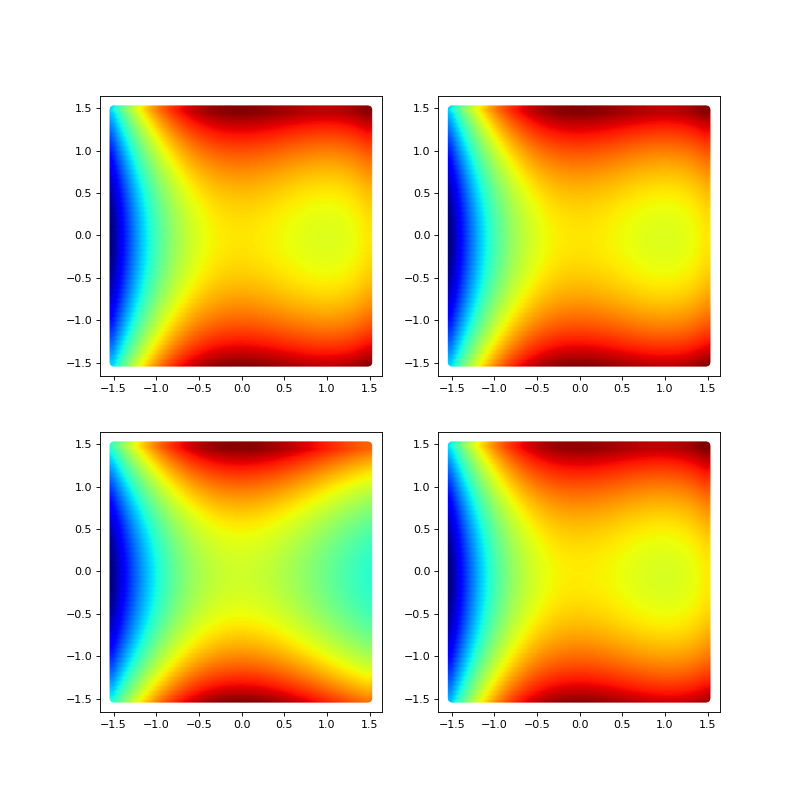

In [588]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0][0].scatter(X, Y, c = H0, cmap = 'jet')
ax[0][1].scatter(X, Y, c = H_num, cmap = 'jet')
ax[1][0].scatter(X, Y, c = H_traj, cmap = 'jet')
ax[1][1].scatter(X, Y, c = H_traj_corrected, cmap = 'jet')

plt.show()

<IPython.core.display.Javascript object>


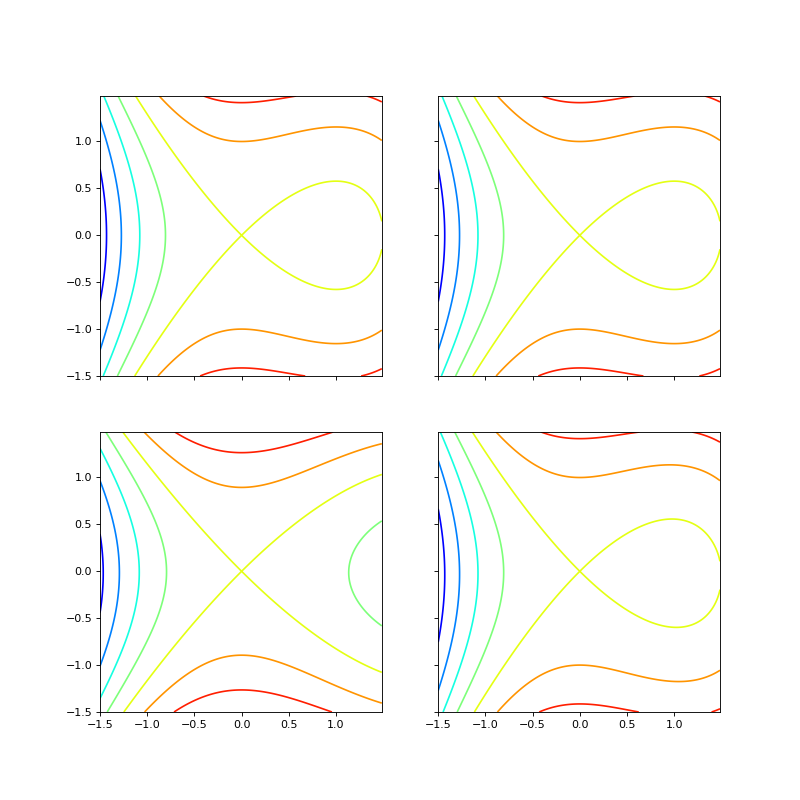

In [589]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

ax[0][0].contour(X, Y, H0, cmap = 'jet')
ax[0][1].contour(X, Y, H_num, cmap = 'jet')
ax[1][0].contour(X, Y, H_traj, cmap = 'jet')
ax[1][1].contour(X, Y, H_traj_corrected, cmap = 'jet')

plt.show()

In [590]:
numpy.mean(RelativeError), numpy.std(RelativeError)

(0.5000922006889365, 0.0034754719176114633)

In [597]:
2*A_hat_mean

array([[1.00000338e+00, 2.00506506e-02],
       [2.89628640e-04, 1.00006574e+00]])

In [596]:
A_hat_mean

array([[5.00001690e-01, 1.00253253e-02],
       [1.44814320e-04, 5.00032868e-01]])

# Invariant Manifold detection via an associated dynamical system

Using a special procedure, found from the fact that $det(D_0^1) = 0$, we're able to obtain the invariant manifolds of the HSN, by using the $det(D_0^1)$ for a data matrix constructed from solving the dynamics of a different dynamical system, which is also a HSN system, but with a slightly different potential, which is related to the original one and can be determined analytically.

Original Potential in HSN

\begin{equation}
V(q) = -\sqrt{\mu}q^2 + \frac{1}{3}q^3
\end{equation}

Potential of the associated system

\begin{equation}
V'(q) = -\sqrt{\mu}q^2 + \frac{2}{9}q^3
\end{equation}

No change of coordinates needed, but only a change in the potential function coefficients, assumed to be polynomial. 

### Routine for Numerical Soltution

In [102]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
MU = 0.25
ALPHA = 1
# Bundle parameters for ODE solver
params = [MU, ALPHA]

def f(y, t, params):
    q, p = y      # unpack current values of y
    MU, ALPHA = params  # unpack parameters
    derivs = [p, 2*numpy.sqrt(MU)*q - (2/3)*q**2]     # list of dy/dt=f functions
    return derivs
###########################################
#
# Meshgrid of initial conditions (q0,p0)
#
###########################################
# Grid limits
x_min, x_max = (-1.5, 1.5)
y_min, y_max = (-1.5, 1.5)
# Number of grid points per axis
N = 200
# Grid resolution per axis
x_res = (x_max - x_min)/float(N)
y_res = x_res
# Construct grid for the above params
x = np.arange(x_min, x_max, x_res)
y = np.arange(y_min, y_max, y_res)
X,Y = np.meshgrid(x, y)
###########################################
#
# Make time array for solution
#
###########################################
n_steps = 1
t0 = 0.
t_final = t0 + n_steps*dt
dt = 0.02 # Time increment
t = np.arange(t0, t_final+dt, dt)
###########################################
#
# Solve ODEs for every initial condition in grid
#
###########################################
D01_det_data = []
A_hat_data = []
grid_points = []
trajectory = {}
for i in range(len(X[0])):
    trajectory[i] = {}    
    for j in range(len(Y[0])):
        q0 = float(X[i][j])
        p0 = float(Y[i][j])
        grid_points.append([q0, p0])
        ###########################################
        #
        # Solve ODEs for initial conditions (q0, p0)
        #
        ###########################################
        # Bundle initial conditions for ODE solver
        y0 = [q0, p0]
        # Call ODE solver
        solution = odeint(f, y0, t, args=(params,))
        # Vector for next step in evolution and its P-inverse
        trajectory[i][j] = solution
        ###########################################
        #
        # Data matrices and their determinant 
        #
        ###########################################
        # Column vector of IC.s and its MP-pseudoinverse
        q0, p0 = solution[0]
        r0 = numpy.matrix([q0, p0]).T
        q, p = solution[1]
        r = numpy.matrix([q, p]).T
        # Data matrix D_0^1
        D01 = numpy.asmatrix(numpy.concatenate([[r0],[r]])).T
        D01_det = numpy.linalg.det(D01)
        D01_det_data.append(D01_det)
        ###########################################
        #
        # Trajectory-based operator for IC
        #
        ###########################################
        r0_pinv = r0.T/float(numpy.linalg.norm(r0)**2)
        A_hat = numpy.matmul(r, r0_pinv)
        A_hat_data.append(A_hat)

### Invertibility Plot of $D_0^1$ matrices

<IPython.core.display.Javascript object>


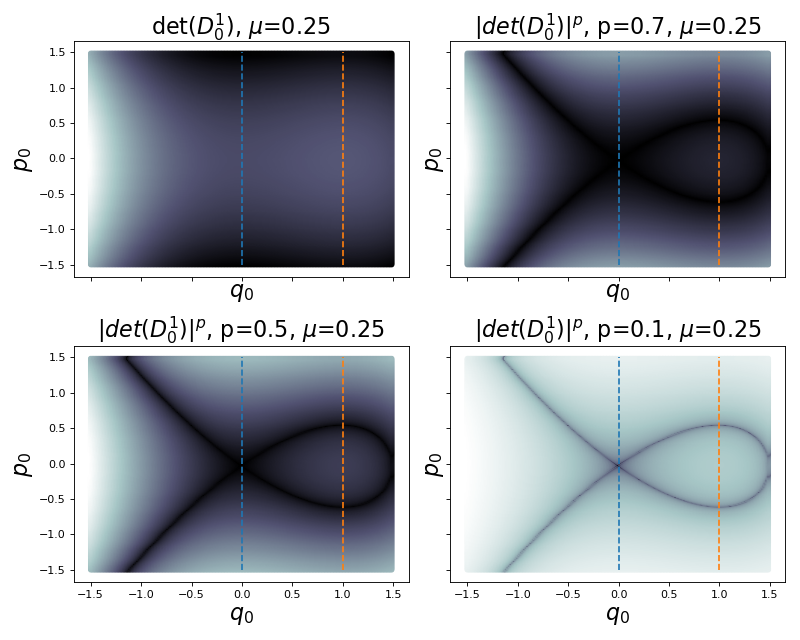

In [601]:
import matplotlib
fig,ax = plt.subplots(2,2,figsize=(10,8), sharex =True, sharey=True)

x,y = numpy.asarray(grid_points).T

############################################
i,j=(0,0)
ax[i][j].scatter(x,y,c=D01_det_data,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title('det($D_0^1$), $\mu$=0.25', fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)

############################################
p1 = 0.7
i,j=(0,1)
ax[i][j].scatter(x,y,c=numpy.abs(D01_det_data)**p1,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title("$\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p1)+", $\mu$=0.25", fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)

############################################
p2 = 0.5
i,j=(1,0)
ax[i][j].scatter(x,y,c=numpy.abs(D01_det_data)**p2,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title("$\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p2)+", $\mu$=0.25", fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)


############################################
p3 = 0.1
i,j=(1,1)
ax[i][j].scatter(x,y,c=numpy.abs(D01_det_data)**p3,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title("$\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p3)+", $\mu$=0.25", fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)


fig.tight_layout()
plt.show()

# Original HSN system

\begin{equation}
    H'_{SN} = \frac{1}{2} p^2 - \mu q + \frac{1}{3}q^3
\end{equation}

\begin{align*}
    \dot{q} &= \frac{\partial H'_{SN}}{\partial p} = p\\
    \dot{p} &= -\frac{\partial H'_{SN}}{\partial q} = \mu - q^2
\end{align*}


### Routine for Numerical Soltution

In [103]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
MU = 0.25
ALPHA = 1
# Bundle parameters for ODE solver
params = [MU, ALPHA]

def f(y, t, params):
    q, p = y      # unpack current values of y
    MU, ALPHA = params  # unpack parameters
    derivs = [p, MU - q**2]     # list of dy/dt=f functions
    return derivs
###########################################
#
# Meshgrid of initial conditions (q0,p0)
#
###########################################
# Grid limits
x_min, x_max = (-1.5, 1.5)
y_min, y_max = (-1.5, 1.5)
# Number of grid points per axis
N = 200
# Grid resolution per axis
x_res = (x_max - x_min)/float(N)
y_res = x_res
# Construct grid for the above params
x = np.arange(x_min, x_max, x_res)
y = np.arange(y_min, y_max, y_res)
X,Y = np.meshgrid(x, y)
###########################################
#
# Make time array for solution
#
###########################################
n_steps = 1
t0 = 0.
t_final = t0 + n_steps*dt
dt = 0.02 # Time increment
t = np.arange(t0, t_final+dt, dt)
###########################################
#
# Solve ODEs for every initial condition in grid
#
###########################################
D01_det_data = []
A_hat_data = []
grid_points = []
trajectory = {}
for i in range(len(X[0])):
    trajectory[i] = {}    
    for j in range(len(Y[0])):
        q0 = float(X[i][j])
        p0 = float(Y[i][j])
        grid_points.append([q0, p0])
        ###########################################
        #
        # Solve ODEs for initial conditions (q0, p0)
        #
        ###########################################
        # Bundle initial conditions for ODE solver
        y0 = [q0, p0]
        # Call ODE solver
        solution = odeint(f, y0, t, args=(params,))
        # Vector for next step in evolution and its P-inverse
        trajectory[i][j] = solution
        ###########################################
        #
        # Data matrices and their determinant 
        #
        ###########################################
        # Column vector of IC.s and its MP-pseudoinverse
        q0, p0 = solution[0]
        r0 = numpy.matrix([q0, p0]).T
        q, p = solution[1]
        r = numpy.matrix([q, p]).T
        # Data matrix D_0^1
        D01 = numpy.asmatrix(numpy.concatenate([[r0],[r]])).T
        D01_det = numpy.linalg.det(D01)
        D01_det_data.append(D01_det)
        ###########################################
        #
        # Trajectory-based operator for IC
        #
        ###########################################
        r0_pinv = r0.T/float(numpy.linalg.norm(r0)**2)
        A_hat = numpy.matmul(r, r0_pinv)
        A_hat_data.append(A_hat)

In [104]:
D01_det_hsn['translated'] = D01_det_data

### Invertibility Plot of $D_0^1$ matrices

<IPython.core.display.Javascript object>


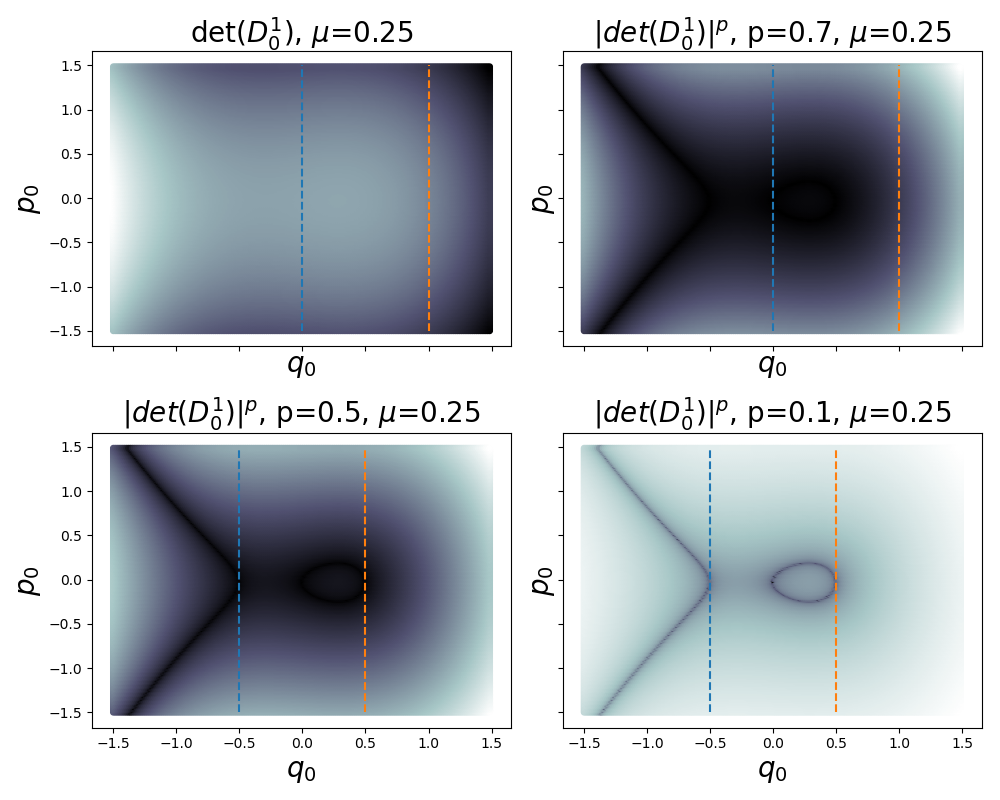

In [16]:
import matplotlib
fig,ax = plt.subplots(2,2,figsize=(10,8), sharex =True, sharey=True)

x,y = numpy.asarray(grid_points).T

############################################
i,j=(0,0)
ax[i][j].scatter(x,y,c=D01_det_data,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title('det($D_0^1$), $\mu$=0.25', fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)

############################################
p1 = 0.7
i,j=(0,1)
ax[i][j].scatter(x,y,c=numpy.abs(D01_det_data)**p1,s=15,cmap='bone')

ax[i][j].plot([0,0],[-1.5,1.5],'--')
ax[i][j].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title("$\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p1)+", $\mu$=0.25", fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)

############################################
p2 = 0.5
i,j=(1,0)
ax[i][j].scatter(x,y,c=numpy.abs(D01_det_data)**p2,s=15,cmap='bone')

ax[i][j].plot([-0.5,-0.5],[-1.5,1.5],'--')
ax[i][j].plot([-0.5+2*numpy.sqrt(MU), -0.5+2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title("$\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p2)+", $\mu$=0.25", fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)


############################################
p3 = 0.1
i,j=(1,1)
ax[i][j].scatter(x,y,c=numpy.abs(D01_det_data)**p3,s=15,cmap='bone')

ax[i][j].plot([-0.5,-0.5],[-1.5,1.5],'--')
ax[i][j].plot([-0.5+2*numpy.sqrt(MU), -0.5+2*numpy.sqrt(MU)],[-1.5,1.5],'--')

ax[i][j].set_title("$\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p3)+", $\mu$=0.25", fontsize=20)
ax[i][j].set_xlabel('$q_0$',fontsize=20)
ax[i][j].set_ylabel('$p_0$',fontsize=20)


fig.tight_layout()
plt.show()

# Comparison Analytical Solutions

<IPython.core.display.Javascript object>


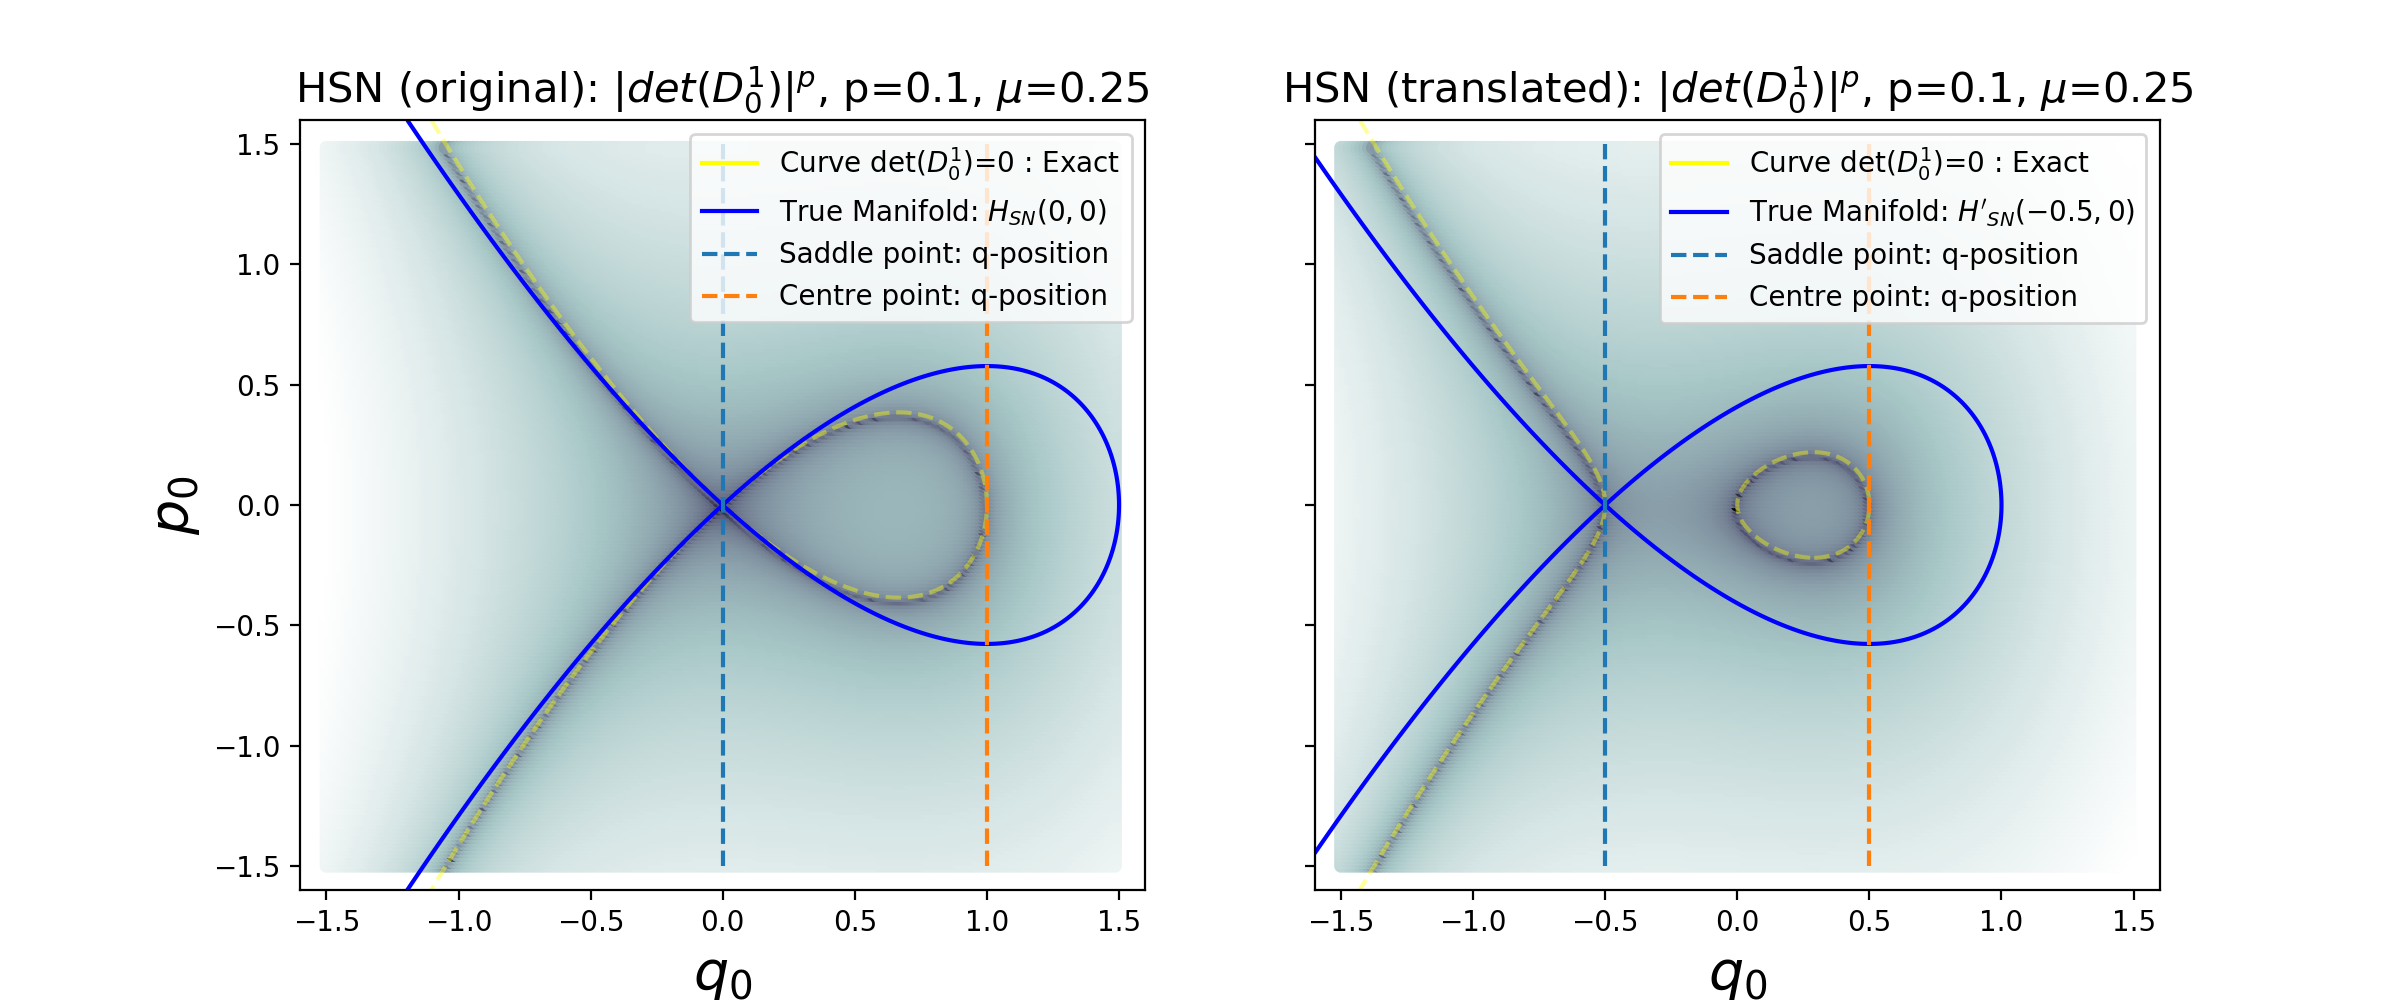

/Users/bas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: The following kwargs were not used by contour: 'label'


In [118]:
MU = 0.25

# Mesh of initial conditions in 2D plane
delta = 0.001
xrange = arange(-1.6, 1.6, delta)
yrange = arange(-1.6, 1.6, delta)
q0, p0 = meshgrid(xrange,yrange)
x,y = numpy.asarray(grid_points).T

fig,ax = plt.subplots(1,2,dpi=200,figsize=(12,5), sharex=True, sharey=True)

#########################################
# F is one side of the equation, G is the other
# FROM NON-INVERTIBILITY
F = 0.5*p0**2 - numpy.sqrt(MU)*q0**2 + 0.5*q0**3
G = 0
ax[0].contour(q0, p0, (F - G), [0], colors='yellow', linewidths=1.5,linestyles='--', alpha=0.4)
ax[0].plot([],[],color='yellow',label='Curve det($D_0^1$)=0 : Exact')

# ACTUAL MANIFOLD
# F is one side of the equation, G is the other
F = 0.5*p0**2 - numpy.sqrt(MU)*q0**2 + (1/3)*q0**3
G = 0
ax[0].contour(q0, p0, (F - G), [0], colors='blue', label='True Manifold')
ax[0].plot([],[],color='blue', label='True Manifold: $H_{SN}(0,0)$')

p = 0.1
ax[0].scatter(x,y,c=numpy.abs(D01_det_hsn['original'])**p,s=15,cmap='bone')
ax[0].plot([0,0],[-1.5,1.5],'--',label='Saddle point: q-position')
ax[0].plot([2*numpy.sqrt(MU), 2*numpy.sqrt(MU)],[-1.5,1.5],'--',label='Centre point: q-position')
ax[0].set_title("HSN (original): $\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p)+", $\mu$=0.25", fontsize=15)
ax[0].set_xlabel('$q_0$',fontsize=20)
ax[0].set_ylabel('$p_0$',fontsize=20)

ax[0].set_xlim(-1.6, 1.6)
ax[0].set_ylim(-1.6, 1.6)
ax[0].legend(loc='best')

#########################################
# Mesh of initial conditions in 2D plane
delta = 0.001
xrange = arange(-1.6, 1.6, delta)
yrange = arange(-1.6, 1.6, delta)
q0, p0 = meshgrid(xrange,yrange)


# F is one side of the equation, G is the other
# FROM NON-INVERTIBILITY
F = 0.5*p0**2 - 0.5*MU*q0 + 0.5*q0**3
G = 0
ax[1].contour(q0, p0, (F - G), [0], colors='yellow',linewidths=1.5,linestyles='--', alpha=0.4)
ax[1].plot([],[],color='yellow',label='Curve det($D_0^1$)=0 : Exact')
# ACTUAL MANIFOLD
# F is one side of the equation, G is the other

F = 0.5*p0**2 - MU*q0 + (1/3)*q0**3 
G = 0.5*MU - 1/24
ax[1].contour(q0, p0, (F - G), [0], colors='blue')
ax[1].plot([],[],color='blue', label="True Manifold: $H'_{SN}(-0.5,0)$")

p = 0.1
ax[1].scatter(x,y,c=numpy.abs(D01_det_hsn['translated'])**p,s=15,cmap='bone')
ax[1].plot([-0.5,-0.5],[-1.5,1.5],'--',label='Saddle point: q-position')
ax[1].plot([-0.5+2*numpy.sqrt(MU), -0.5+2*numpy.sqrt(MU)],[-1.5,1.5],'--',label='Centre point: q-position')
ax[1].set_title("HSN (translated): $\\vert det(D_0^1) \\vert ^p$, "+"p="+str(p)+", $\mu$=0.25", fontsize=15)
ax[1].set_xlabel('$q_0$',fontsize=20)
# ax[1].set_ylabel('$p_0$',fontsize=20)

ax[1].set_xlim(-1.6, 1.6)
ax[1].set_ylim(-1.6, 1.6)
ax[1].legend(loc='best')

plt.show()

# SCRATCH NOTES

## Notes: Group Meeting

* Use RK 4order
* Check energy conservation

In [381]:
Z0 = np.zeros_like(X)
Z1 = np.zeros_like(X)
dZ = np.zeros_like(X)
for i in range(len(X[0])):
    for j in range(len(Y[0])):
        r0,r1 = trajectory[i][j]
        q0,p0 = r0
        H0 = 0.5*p0**2 - numpy.sqrt(MU)*q0**2 + ALPHA*q0**3/3
        q1,p1 = r1
        H1 = 0.5*p1**2 - numpy.sqrt(MU)*q1**2 + ALPHA*q1**3/3
#         speed = numpy.linalg.norm(q1 - q0)
        Z0[i][j] = H0
        Z1[i][j] = H1
        dZ[i][j] = abs(H1-H0)

ValueError: setting an array element with a sequence.

## Runge-Kutta Implementation

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import RK45

# Parameters
MU = 0.0
ALPHA = 1

def f(t, y):
    q, p = y      # unpack current values of y
    MU, ALPHA = params  # unpack parameters
    derivs = [p, 2*numpy.sqrt(MU)*q - q**2] # list of dy/dt=f functions
    return derivs

# Meshgrid of initial conditions (q0,p0)
x_min, x_max = (-1.5, 1.5)
y_min, y_max = (-1.5, 1.5)

N = 100
x_res = (x_max - x_min)/float(N)
y_res = x_res

x = np.arange(x_min, x_max, x_res)
y = np.arange(y_min, y_max, y_res)
X,Y = np.meshgrid(x, y, sparse=True)

D01_det_data = []
grid_points = []
data = []
for i in range(len(X[0])):
    q0 = float(X[0][i])
    for j in range(len(Y)):
        p0 = float(Y[j])
        grid_points.append([q0, p0])
        # Column vector of IC.s and its MP-pseudoinverse
        r0 = numpy.matrix([q0,p0]).T
        r0_pinv = r0.T/float(numpy.linalg.norm(r0))
        
        # Bundle parameters for ODE solver
        params = [MU, ALPHA]

        # Bundle initial conditions for ODE solver
        y0 = [q0, p0]

        # Make time array for solution
        dt = 0.02 # Increment
        t_initial = 0
        t_final = dt

        # Call the ODE solver
        solution = RK45(f,t_initial,y0,t_final)
        # collect data
        t_values = []
        y_values = []
        for i in range(100):
            # get solution step state
            solution.step()
            t_values.append(solution.t)
            y_values.append(solution.y)
            # break loop after modeling is finished
            if solution.status == 'finished':
                break

        data.append([t_values, y_values[-1]])
        
        # Vector for next step in evolution and its P-inverse
#         q, p = psoln[1]
#         r = numpy.matrix([q, p]).T
        
#         # Trajectory-based operator for IC
#         A_hat = numpy.matmul(r, r0_pinv)
        
#         # Data matrix D_0^1
#         D01 = numpy.asmatrix(numpy.concatenate([[r0],[r]])).T
#         D01_det = numpy.linalg.det(D01)
#         D01_det_data.append(D01_det)
        
#         ax.scatter(q0,p0,c='blue',s=5)
#         twopi = 1.7
#         ax.plot(psoln[:,0], psoln[:,1],c='green')
#     #     ax.scatter(psoln[1][0], psoln[1][1],'o',c='blue')

# # ax.plot([-numpy.sqrt(MU), -numpy.sqrt(MU)],[-0.6,0.6],'--',c='blue',label='q: Saddle point')
# ax.set_xlabel('q', fontsize=20)
# ax.set_ylabel('p', fontsize=20)
# ax.set_xlim(-1.55, twopi)
# # ax.legend()

# plt.tight_layout()
# plt.show()

In [178]:
D01_det_data = []
for i in range(len(X[0])):
    q0 = float(X[0][i])
    for j in range(len(Y)):
        p0 = float(Y[j])
        # Column vector of IC.s and its MP-pseudoinverse
        r0 = numpy.matrix([q0, p0]).T
        r0_pinv = r0.T/float(numpy.linalg.norm(r0))
        
        # Vector for next step in evolution and its P-inverse
        q, p = data[i][-1]
        r = numpy.matrix([q, p]).T
        
        # Trajectory-based operator for IC
        A_hat = numpy.matmul(r, r0_pinv)
        
        # Data matrix D_0^1
        D01 = numpy.asmatrix(numpy.concatenate([[r0],[r]])).T
        D01_det = numpy.linalg.det(D01)
        D01_det_data.append(D01_det)

## Random Sampling of Initial Conditions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def f(y, t, params):
    q, p = y      # unpack current values of y
    MU, ALPHA = params  # unpack parameters
    derivs = [p, MU - q**2]     # list of dy/dt=f functions
    return derivs

# Parameters
MU = 0.25
ALPHA = 1

# Initial values
# Parameters for non-closed path
#q0 = -numpy.sqrt(MU)+0.001 # initial angular displacement
#p0 = 0.01    # initial angular velocity

# Parameters closed-path
# q0 = -numpy.sqrt(MU)-0.05 # initial angular displacement
# p0 = 0.0    # initial angular velocity

# Plot results
fig,ax = plt.subplots(1,1,figsize=(8,8))

R0 = 2.5*numpy.random.rand(2,10000)-1 # Initial conditions
R0 = R0.T

D01_det_data = []
for i in range(len(R0)):
    q0, p0 = R0[i]
    
    # Column vector of IC.s and its MP-pseudoinverse
    r0 = numpy.matrix([q0,p0]).T
    r0_pinv = r0.T/float(numpy.linalg.norm(r0))
    
    # Bundle parameters for ODE solver
    params = [MU, ALPHA]

    # Bundle initial conditions for ODE solver
    y0 = [q0, p0]

    # Make time array for solution
    tStop = 0.04
    tInc = 0.02
    t = np.arange(0., tStop, tInc)

    # Call the ODE solver
    psoln = odeint(f, y0, t, args=(params,))
    
    # Vector for next step in evolution and its P-inverse
    q, p = psoln[1]
    r = numpy.matrix([q, p]).T
    
    # Trajectory-based operator for IC
    A_hat = numpy.matmul(r, r0_pinv)
    
    # Data matrix D_0^1
    D01 = numpy.asmatrix(numpy.concatenate([[r0],[r]])).T
    D01_det = numpy.linalg.det(D01)
    D01_det_data.append(D01_det)
    
    ax.scatter(q0,p0,c='blue')
    twopi = 1.7
    ax.plot(psoln[:,0], psoln[:,1],c='green')
#     ax.scatter(psoln[1][0], psoln[1][1],'o',c='blue')
    

# ax.plot([-numpy.sqrt(MU), -numpy.sqrt(MU)],[-0.6,0.6],'--',c='blue',label='q: Saddle point')
ax.set_xlabel('q', fontsize=20)
ax.set_ylabel('p', fontsize=20)
ax.set_xlim(-1.5, twopi)
# ax.legend()

plt.tight_layout()
plt.show()

## Code block to plot $det(D_0^1)$

<IPython.core.display.Javascript object>


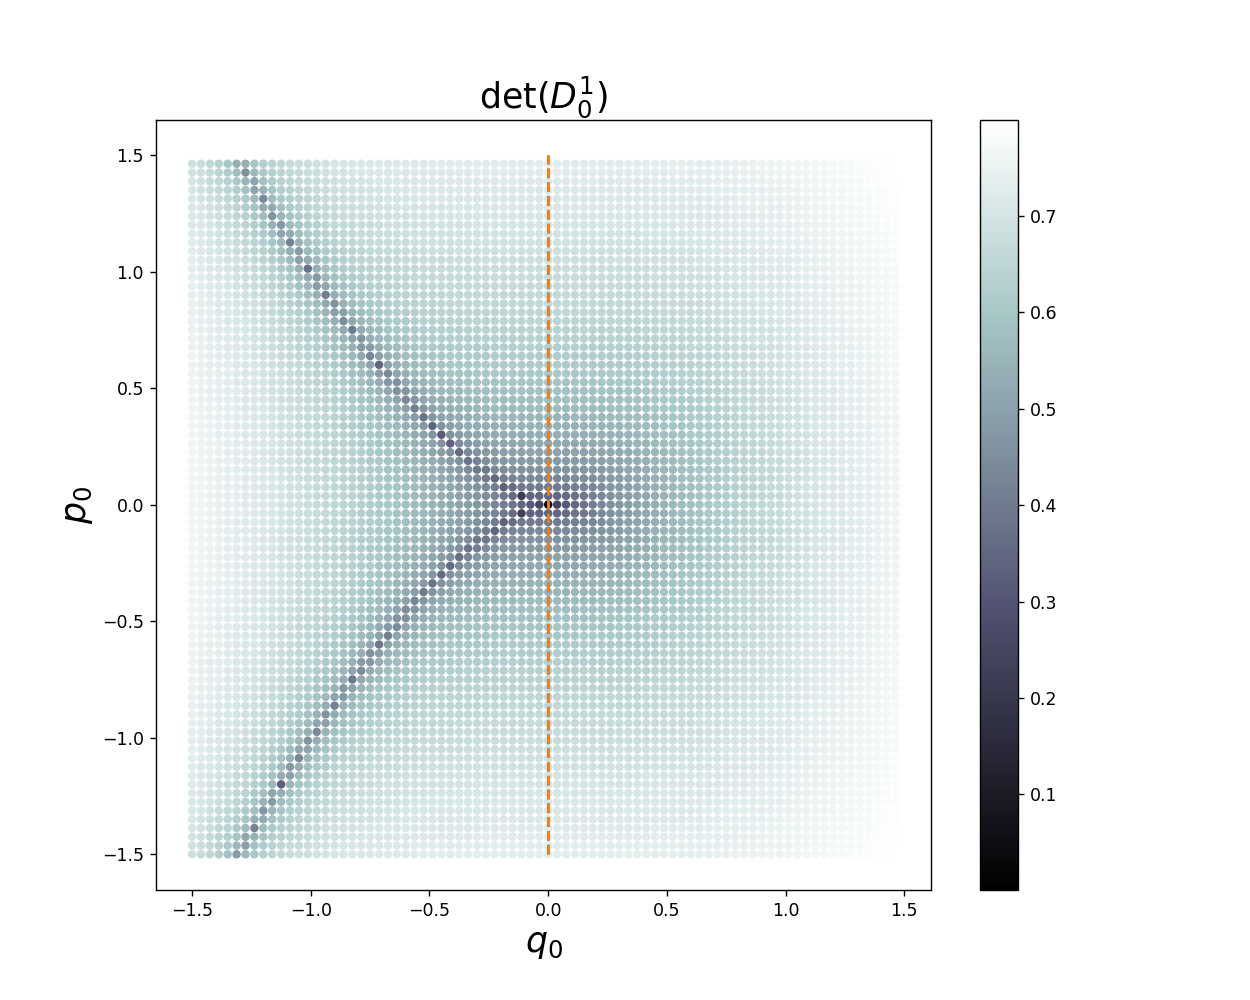

In [237]:
import matplotlib
fig,ax = plt.subplots(1,1,figsize=(10,8))

x,y = numpy.asarray(grid_points).T
s = ax.scatter(x,y,c = numpy.abs(D01_det_data)**0.1,s=15,cmap='bone')
ax.plot([-numpy.sqrt(MU), -numpy.sqrt(MU)],[-1.5,1.5],'--')
ax.plot([numpy.sqrt(MU), numpy.sqrt(MU)],[-1.5,1.5],'--')
ax.set_title('det($D_0^1$)', fontsize=20)
ax.set_xlabel('$q_0$',fontsize=20)
ax.set_ylabel('$p_0$',fontsize=20)
fig.colorbar(s)
plt.show()